In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import collections
import queue
import scipy.io as spio
from scipy.spatial import distance
import random

class K_means:
    # num_centroids: número de centroids escolhido
    # dados: conjunto de dados que sera utilizado
    # num_iter: número de iterações que devemos submeter o conjunto de dados
    def __init__(self, num_centroids, dados, num_iter):
        self.num_centroids = num_centroids
        self.dados = dados
        self.num_iter = num_iter
    
    def calc_distance(self, x, y):
        return distance.euclidean(x,y)

    def findClosestCentroids(self, ic, X):
        assigned_centroids = []
        for i in X:
            distance = []
            for j in ic:
                distance.append(self.calc_distance(i,j))
            assigned_centroids.append(np.argmin(distance))
        return assigned_centroids


    def calc_centroids(self, clusters, X):
        new_centroids = []
        new_df = pd.concat([pd.DataFrame(X), pd.DataFrame(clusters, columns=['cluster'])],
                        axis=1)
        for c in set(new_df['cluster']):
            current_cluster = new_df[new_df['cluster'] == c][new_df.columns[:-1]]
            cluster_mean = current_cluster.mean(axis=0)
            new_centroids.append(cluster_mean)
        return new_centroids
    
    def runKmeans(self):
        dataArray = np.array(self.dados)
        print("Dataset em vetor")
        print(dataArray)
        # Inicializa num_centroids índices de centroids escolhidos aleatoriamente
        init_centroids = random.sample(range(0, len(self.dados)), self.num_centroids)
        print("Índices dos Centroids escolhidos")
        print(init_centroids)
        # Recupera o valor de cada um dos índices de centroids escolhidos
        centroids = []
        for i in init_centroids:
            centroids.append(self.dados.loc[i])
        centroids = np.array(centroids)
        print("Valores dos centroids escolhidos")
        print(centroids)
        
        for i in range(self.num_iter):
            get_centroids = self.findClosestCentroids(centroids, dataArray)
            centroids = self.calc_centroids(get_centroids, dataArray)
            plt.figure()
            plt.scatter(np.array(centroids)[:, 0], np.array(centroids)[:, 1], color='black')
            plt.scatter(dataArray[:, 0], dataArray[:, 1], alpha=0.1)
            plt.show()



Dataset em vetor
[[0.36969697 0.98161765]
 [0.35       0.94117647]
 [0.33636364 0.97058824]
 ...
 [0.96666667 0.88419118]
 [0.98030303 0.88970588]
 [0.94090909 0.86948529]]
Índices dos Centroids escolhidos
[203, 525, 546]
Valores dos centroids escolhidos
[[0.29848485 0.27205882]
 [0.97424242 0.77022059]
 [0.81515152 0.82169118]]


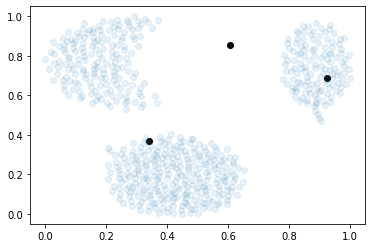

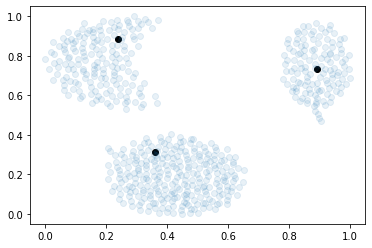

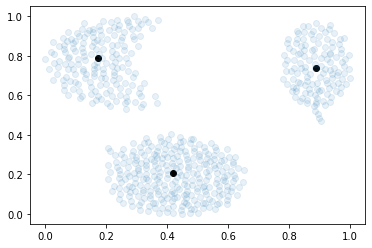

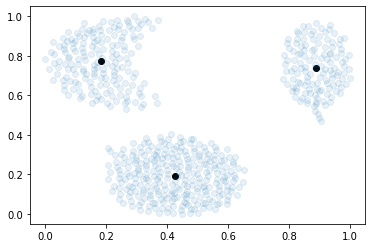

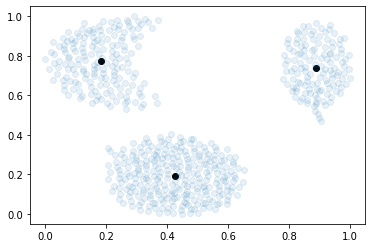

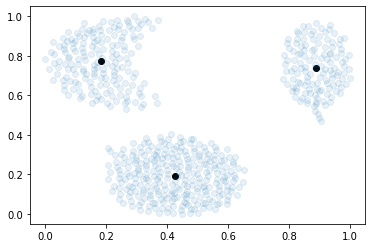

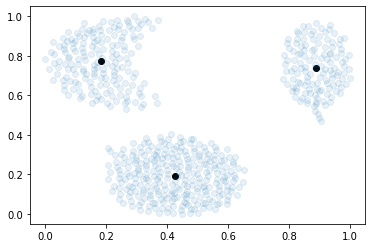

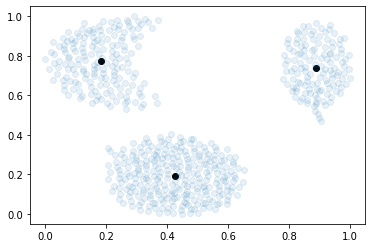

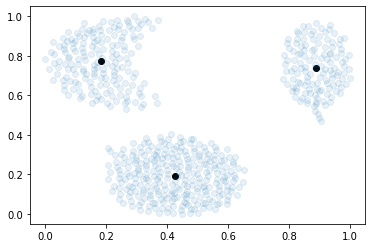

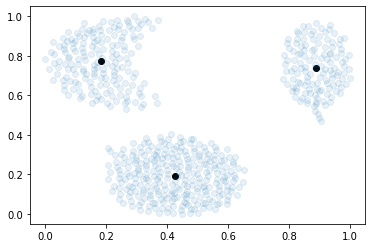

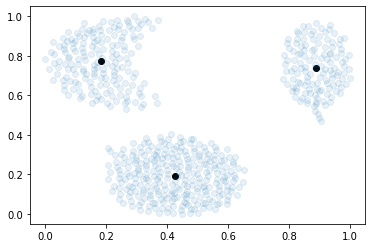

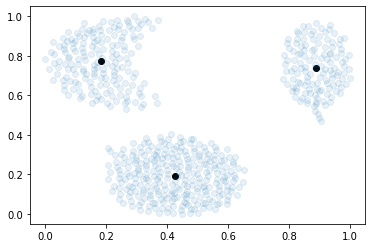

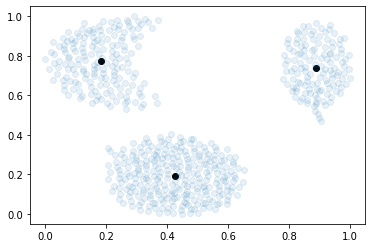

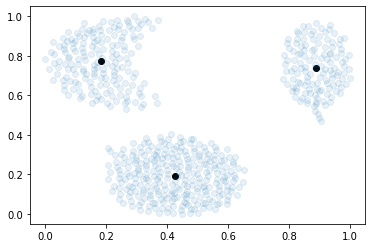

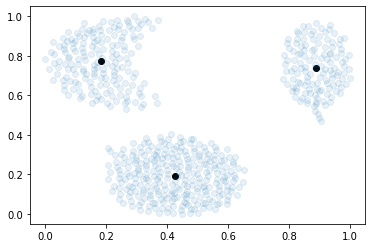

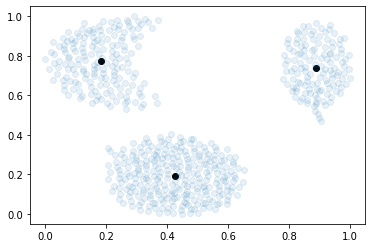

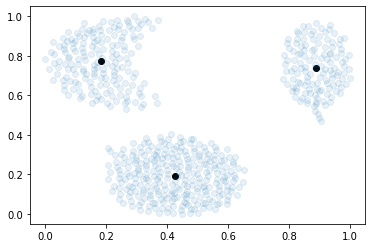

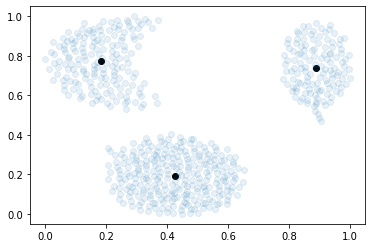

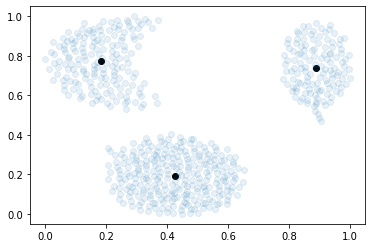

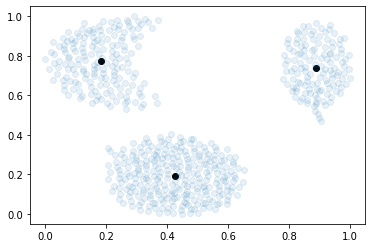

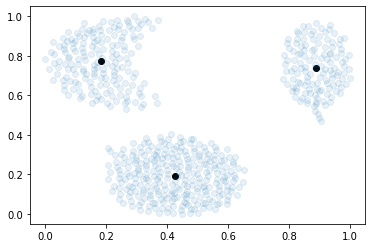

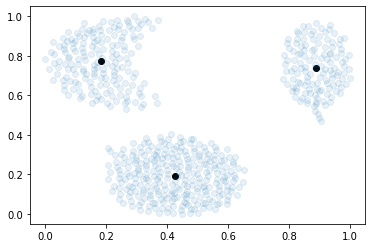

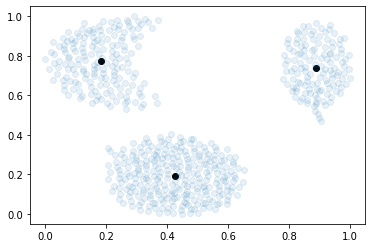

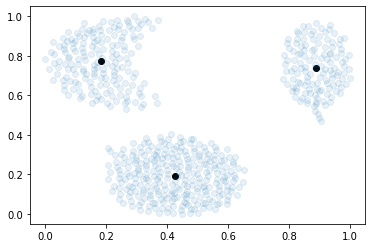

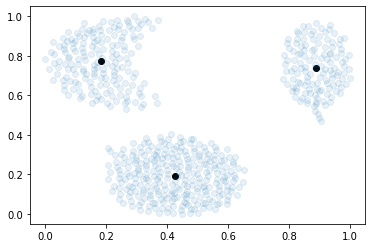

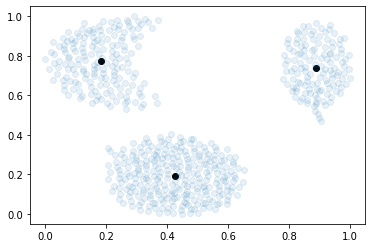

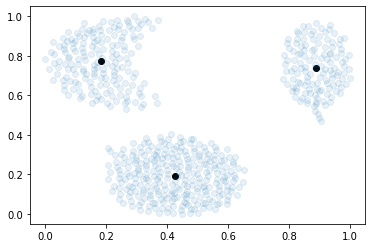

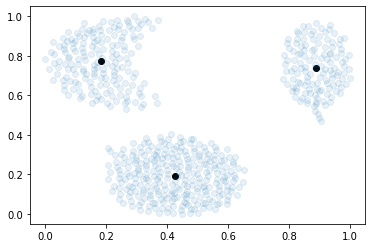

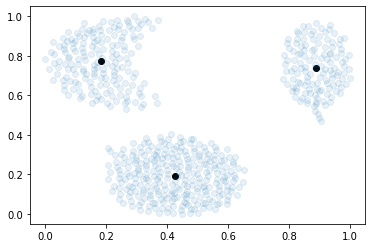

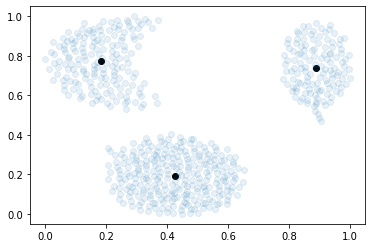

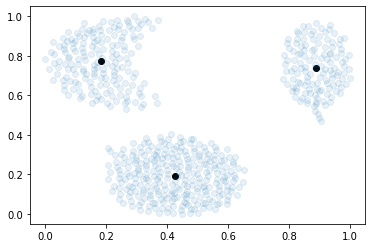

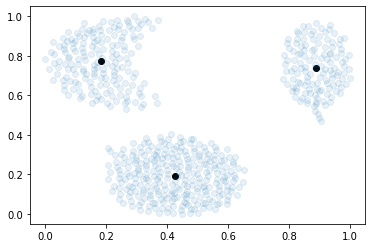

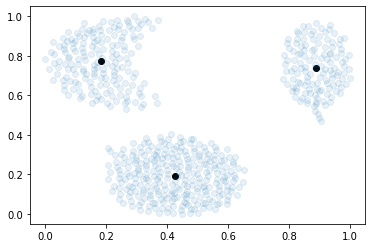

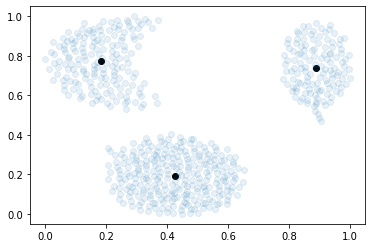

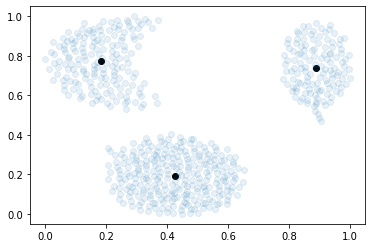

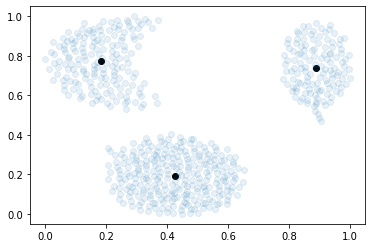

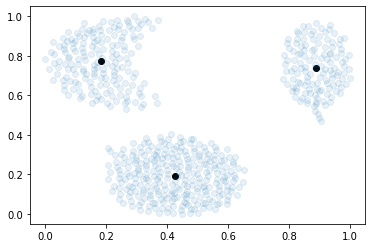

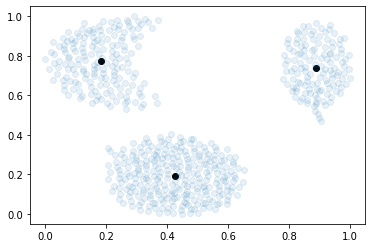

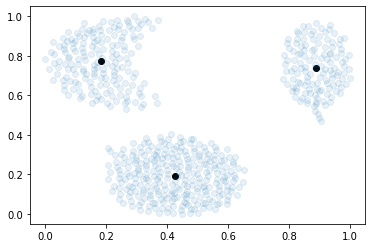

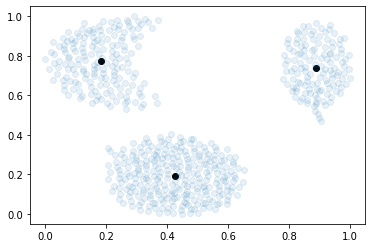

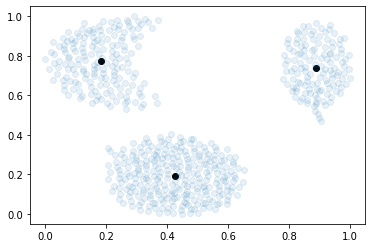

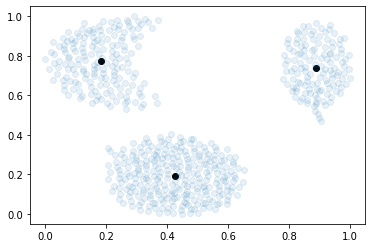

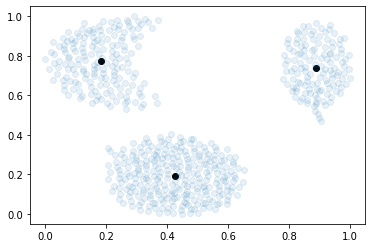

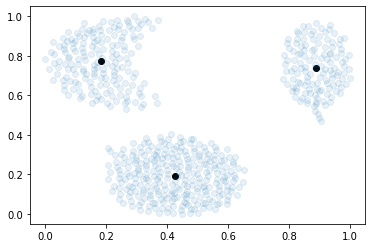

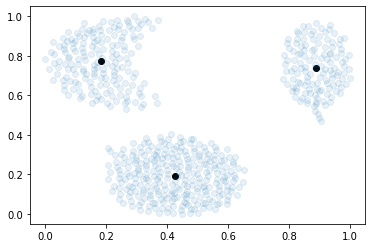

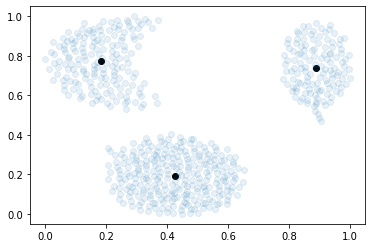

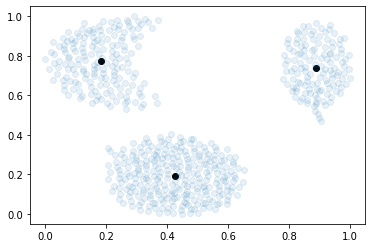

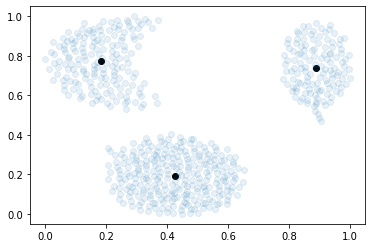

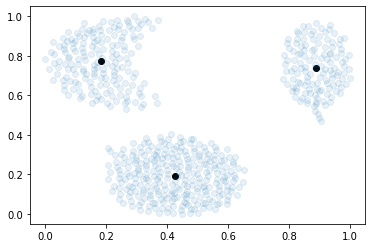

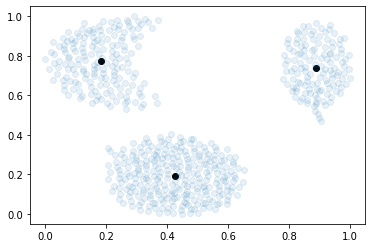

In [9]:
# Carrega o dataset
data_input = [i.strip().split() for i in open("./cluster.dat").readlines()]
data_input = pd.DataFrame(data_input)
data_input[0] = pd.to_numeric(data_input[0])
data_input[1] = pd.to_numeric(data_input[1])

# Normaliza o dataset
def normalization(x, min_x, max_x):
    return (x - min_x) / (max_x - min_x) 
data_input[0] = data_input[0].apply(lambda x: normalization(x, min(data_input[0]), max(data_input[0])))
data_input[1] = data_input[1].apply(lambda x: normalization(x, min(data_input[1]), max(data_input[1])))

# Instancia a classe do K-means
k_means = K_means(3, data_input, 50)
k_means.runKmeans()
